# Exercise 2.5

First of all, we import usefull libraries.

In [1]:
import numpy as np
import random
import math as math
import matplotlib.image as img
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as _Image
from mpl_toolkits.mplot3d import Axes3D

We get all unique colors because of performance reasons. We want to put pixels between different clusters to black so, in order to do that, we're comparing one pixel with the previous and upper one.

We define two lists, $pixels$ (image we're saving) and $pixels\_old$ (image with colors from assignation matrix). Both are defined with one added row. Nevertheless, it's no important, because it's not taked into account when saved.

In [2]:
class ImageConversion:

    def get_image_from_url(self, img_url):
        image = open(img_url,'rb')
        return img.imread(image)

    def get_unique_colours(self, image_matrix):
        feature_matrix = []
        nf, nc, o = np.shape(image_matrix)
        for i in range(nf):
            for j in range(nc):
                feature_matrix.append(image_matrix[i, j]) # Stores RGB values of each point of the image
        feature_matrix_np = np.array(feature_matrix)
        uniques, index = np.unique([str(i) for i in feature_matrix_np], return_index = True)
        return feature_matrix_np[index], feature_matrix # Unique points and the calculated array

    def save_image(self, size, pixel_matrix, unique_matrix, assignation_matrix, colours, output):
        image_out = Image.new("RGB", size)
        
        nf, nc = size
        pixels = [0]*nf
        pixels_old = [0]*nf
        aux = nf
        
        for i in range(len(pixel_matrix)): # It goes through all pixels
            pixel_list = pixel_matrix[i].tolist()
            
            for j in range(len(unique_matrix)): # It goes through all different colors
                if pixel_list == unique_matrix[j].tolist():
                    
                    for k in range(len(colours)): # Colours = centers
                        if assignation_matrix[j][k] == 1:
                            segmented_colours = tuple([int(i) for i in (colours[k]*255)])
                            pixels_old.append(segmented_colours)
                            
                            if np.array_equal(pixels_old[-2], segmented_colours) == False or np.array_equal(pixels_old[aux-nf], segmented_colours) == False:
                                if aux > 2*nf:
                                    segmented_colours = tuple([0, 0, 0])
                            pixels.append(segmented_colours)
                            aux += 1
        
        image_out.putdata(pixels[nf:])
        image_out.save(output)

As we saw in lectures, the Segmentation class has the same methods as hard k-means. The assignation matrix is related to the number of unique colors in the image. Centers are set in the RGB color space.

In [3]:
class Segmentation:

    def __init__(self, feature_matrix, groups):
        self.__data_set = feature_matrix
        self.__groups = groups
        self.__space=[[0, 255], [0, 255], [0, 255]]
        self.__error_margin = 0.5
        self.assignation = np.zeros((len(self.__data_set), self.__groups))
        self.centers = []
        self.select_centers()

    def select_centers(self):
        if len(self.centers) == 0:
            iter = 0
            while iter < self.__groups:
                self.centers.append(((random.randrange(0, 255) * 1.0 / 255),
                                     (random.randrange(0, 255) * 1.0 / 255),
                                     (random.randrange(0, 255) * 1.0 / 255)))
                iter=iter+1

    def calculate_distance(self, x, v):
        return math.sqrt((x[0]-v[0])**2+(x[1]-v[1])**2+(x[2]-v[2])**2)
        #return np.linalg.norm(x-v)
    
    def calculate_u(self, x, i):
        smallest_distance = float(self.calculate_distance(x, self.centers[0]))
        smallest_id = 0
        for i in range(1, self.__groups):
            distance = self.calculate_distance(x, self.centers[i])
            if distance < smallest_distance:
                smallest_id = i
                smallest_distance = distance
        distance = np.zeros(self.__groups)
        distance[smallest_id] = 1
        return distance

    def calculate_new_centers(self, u):
        new_centers = []
        for c in range(self.__groups):
            u_x_vector = np.zeros(len(self.centers[0]))
            u_scalar = 0
            for i in range(len(u)):
                u_scalar = u_scalar + u[i][c]
                u_x_vector = np.add(u_x_vector, np.multiply(u[i][c], self.__data_set[i]))
            new_centers.append(np.divide(u_x_vector,u_scalar))
        self.centers = new_centers

    def calculate_differences(self,new_assignation):
        diff = 0
        for i in range(len(self.assignation)):
            for j in range(self.__groups):
                diff += abs(float(new_assignation[i][j]) - float(self.assignation[i][j]))
        return diff

    def do_segmentation(self):
        difference_limit_not_achieved = True
        iter = 0
        while difference_limit_not_achieved:
            new_assignation = []
            for i in range(len(self.__data_set)):
                new_assignation.append(self.calculate_u(self.__data_set[i], iter))
            self.calculate_new_centers(new_assignation)

            if iter > 0:
                if self.calculate_differences(new_assignation) < self.__error_margin:
                    difference_limit_not_achieved = False
            self.assignation = new_assignation
            iter += 1

    def get_results(self):
        return self.centers, self.assignation

It's the same code we saw in class.

In [4]:
image_to_segment = "images/logo_krakow.png"
image_converter = ImageConversion()
image_data = image_converter.get_image_from_url(image_to_segment)
unique_image_data, image_data_list = image_converter.get_unique_colours(image_data)

groups = 3

segmentation = Segmentation(unique_image_data, groups)
segmentation.do_segmentation()
centers, assignation_matrix = segmentation.get_results()

image_size = (232, 258)
image_converter.save_image(image_size, image_data_list, unique_image_data, assignation_matrix, centers, "images/segmented.png")

The converted image is given as below. We see that there are only three colors in the image plus black separation between clusters. However, this method seems not to be the most efficient one, because it takes a lot of time. 

Instead I didn't do it like that, it may be possible to define some function which looks for gradients in the final image. This way, we could set that points where it changes from one to another group to black in a more efficient way.

Some points seem not to be well separated, but it could be due to low quality of the image.

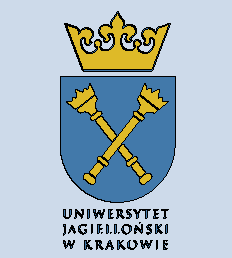

In [5]:
_Image("images/segmented.png")